In [29]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso 


def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4


def create_X(x, y, n):
    """Returns the design matrix X from coordinates x and y with n polynomial degrees."""
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # Number of elements in beta
    X = np.ones((N, l))

    for i in range(1, n + 1):
        q = int(i * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x**(i - k)) * (y**k)

    return X


def MSE(y_actual, y_model):
    """Returns the mean squared error of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return np.mean((y_actual - y_model)**2)


def R2_score(y_actual, y_model):
    """Returns the R2 score of the two arrays."""
    y_actual, y_model = y_actual.ravel(), y_model.ravel()  # flatten arrays
    return 1 - np.sum((y_actual - y_model)**2) / np.sum((y_actual - np.mean(y_actual))**2)


# PARAMETERS
N = 1000  # number of data points
maxdegree = 6  # max polynomial degree for plotting
noise_std = 1

# Figure output directory
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()

# Create data set
np.random.seed(2023)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

# Get franke function with noise
noise = np.random.normal(0, noise_std, x.shape)
z = FrankeFunction(x, y) + noise

# Initialize scaler and lasso regression
scaler = StandardScaler()
lasso = Lasso(fit_intercept=False)  # include intercept

degrees = np.arange(0, maxdegree, 1)
train_mse = np.empty(degrees.shape)
test_mse = np.empty_like(train_mse)
train_r2 = np.empty_like(train_mse)
test_r2 = np.empty_like(train_mse)
beta_arr = []

# Iterate through all the different polynomial degrees
for degree in degrees:
    # Create design matrix X
    X = create_X(x, y, n=degree)  # intercept included
    
    # Split in training and test data up to the given degree
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scale data
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Lasso regression
    lasso.fit(X_train_scaled, z_train)
    z_tilde = lasso.predict(X_train_scaled)
    z_predict = lasso.predict(X_test_scaled)

    # Store the MSE and R2 values
    train_mse[degree] = MSE(z_train, z_tilde)
    test_mse[degree] = MSE(z_test, z_predict)
    train_r2[degree] = R2_score(z_train, z_tilde)
    test_r2[degree] = R2_score(z_test, z_predict)

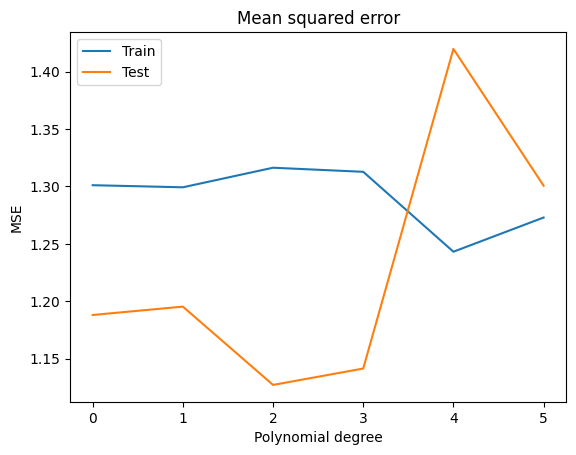

In [30]:
# Plot the MSE as function of poly. degree
plt.plot(degrees, train_mse, label="Train")
plt.plot(degrees, test_mse, label="Test")
plt.legend()
plt.title("Mean squared error")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.savefig(FIGURES_DIR / "part_c_MSE.png")

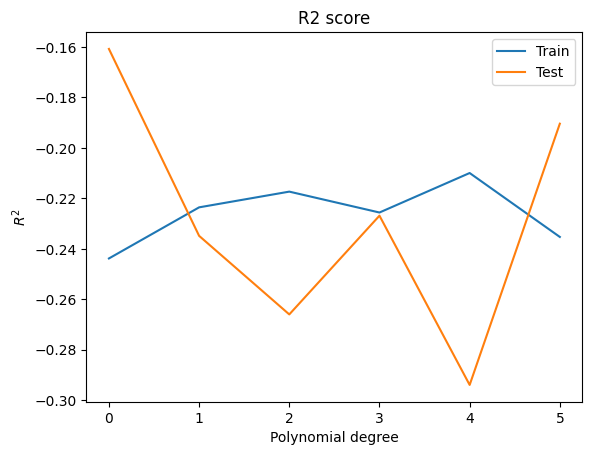

In [31]:
# Plot R2 scores as function of poly. degree 
plt.plot(degrees, train_r2, label="Train")
plt.plot(degrees, test_r2, label="Test")
plt.legend()
plt.title("R2 score")
plt.xlabel("Polynomial degree")
plt.ylabel("$R^2$")
plt.savefig(FIGURES_DIR / "part_c_R2.png")